In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.16.2
1 Physical GPUs, 1 Logical GPUs


In [4]:
# clean for debug purpose only 

trainData = None
valData = None
testData = None
model = None

tf.keras.backend.clear_session(free_memory=True)


## Loading the data

Since there were multiple labels, I decided to write a custom import for the images and labels.

I calculated the weights for each label, so that I can use them later on for a custom loss function and metric.

In [6]:
# load images and labels 
from collections import Counter
import csv

imageFileNames = tf.data.Dataset.list_files('./images/*', shuffle=False)

allLabelDict = {}

numTrainImages = 0
labelDict = Counter()
cellShapeDict = Counter()
nucleusShapeDict = Counter()
cytoplasmVacuoleDict = Counter()

# loads the labels from the csv 
with open("./dev_data_2025.csv", "r") as f:
	csvItems = list(csv.DictReader(f))
	for imgLabel in csvItems:
		numTrainImages += 1
		labelDict[imgLabel['label']] += 1
		cellShapeDict[imgLabel['cell_shape']] += 1
		nucleusShapeDict[imgLabel['nucleus_shape']] += 1
		cytoplasmVacuoleDict[imgLabel['cytoplasm_vacuole']] += 1

	labelTuple = tuple(labelDict.keys())
	cellShapeTuple = tuple(cellShapeDict.keys())
	nucleusShapeTuple = tuple(nucleusShapeDict.keys())
	cytoplasmVacuoleTuple = tuple(cytoplasmVacuoleDict.keys())
	
	for imgLabel in csvItems:
		allLabelDict[imgLabel['imageID']] = [
			labelTuple.index(imgLabel['label']), 
			cellShapeTuple.index(imgLabel['cell_shape']), 
			nucleusShapeTuple.index(imgLabel['nucleus_shape']), 
			cytoplasmVacuoleTuple.index(imgLabel['cytoplasm_vacuole'])
		]

# A weighting for the classes to help prevent over fitting to over represented classes 
classWeightsRaw = {
	'label': {key: (labelDict[key] / numTrainImages) for key in labelTuple},
	'cellShape': {key: (cellShapeDict[key] / numTrainImages) for key in cellShapeTuple},
	'nucleusShape': {key: (nucleusShapeDict[key] / numTrainImages) for key in nucleusShapeTuple},
	'cytoplasmVacuole': {key: (cytoplasmVacuoleDict[key] / numTrainImages) for key in cytoplasmVacuoleTuple}
}

classWeights = {key: np.array([weight**-1 for weight in weights.values()]) for key, weights in classWeightsRaw.items()} 

# Estimate the accuracy of a model maKing random guesses  
classRandomAcc = {
	'label': sum([(i / numTrainImages)**2 for i in labelDict.values()]),
	'cellShape': sum([(i / numTrainImages)**2 for i in cellShapeDict.values()]),
	'nucleusShape': sum([(i / numTrainImages)**2 for i in nucleusShapeDict.values()]),
	'cytoplasmVacuole': sum([(i / numTrainImages)**2 for i in cytoplasmVacuoleDict.values()])
}

print(f'label class imbalance in %: {classWeightsRaw["label"]} | target % {1 / len(labelDict)}')
print(f'label class weights: {classWeights["label"]} | random guess accuracy {classRandomAcc["label"]}')
print(f'cell shape class imbalance in %: {classWeightsRaw["cellShape"]} | target % {100 / len(cellShapeDict)}')
print(f'cell shape class weights: {classWeights["cellShape"]} | random guess accuracy {classRandomAcc["cellShape"]}')
print(f'nucleus shape class imbalance in %: {classWeightsRaw["nucleusShape"]} | target % {100 / len(nucleusShapeDict)}')
print(f'nucleus shape class weights: {classWeights["nucleusShape"]} | random guess accuracy {classRandomAcc["nucleusShape"]}')
print(f'cytoplasm vacuole class imbalance in %: {classWeightsRaw["cytoplasmVacuole"]} | target % {100 / len(cytoplasmVacuoleDict)}')
print(f'cytoplasm vacuole class weights: {classWeights["cytoplasmVacuole"]} | random guess accuracy {classRandomAcc["cytoplasmVacuole"]}')


label class imbalance in %: {'Lymphocyte': 0.1158, 'Monocyte': 0.1358, 'Basophil': 0.1256, 'Neutrophil': 0.322, 'Eosinophil': 0.3008} | target % 0.2
label class weights: [8.63557858 7.36377025 7.96178344 3.10559006 3.32446809] | random guess accuracy 0.24179128
cell shape class imbalance in %: {'round': 0.7808, 'irregular': 0.2192} | target % 50.0
cell shape class weights: [1.2807377 4.5620438] | random guess accuracy 0.65769728
nucleus shape class imbalance in %: {'unsegmented-round': 0.1032, 'unsegmented-indented': 0.1298, 'irregular': 0.0858, 'segmented-multilobed': 0.1252, 'unsegmented-band': 0.258, 'segmented-bilobed': 0.298} | target % 16.666666666666668
nucleus shape class weights: [ 9.68992248  7.70416025 11.65501166  7.98722045  3.87596899  3.3557047 ] | random guess accuracy 0.20590296
cytoplasm vacuole class imbalance in %: {'no': 0.9278, 'yes': 0.0722} | target % 50.0
cytoplasm vacuole class weights: [ 1.0778185  13.85041551] | random guess accuracy 0.8660256799999999


## Creating the tensorflow dataset

Now that I had the data I needed to create the tensorflow dataset that supports multiple labels because the model will need to classify multiple classes.

I used the map function on the image files already imported to load the Images into [360, 360, 3] tensors and then I added the labels generated above. 

The labels needed to be in the form of a dict for the loss function to read them correctly but `py_function` only returns tensors so I had to add an extra function to convert the labels again. 

To improve the training I added some basic data augmentation that randomizes the orientation of the images used for training. 
I chose to only change the orientation because other factors liKe brightness and contrast was fairly consistent across the whole dataset due to the fact that the cell imaging machine produced fairly uniform brightness images.      

I used a 70/30 split for training and validation data and the rest was already designated as test.

In [57]:
valSize = int(numTrainImages * 0.3)
batchSize = 100

In [58]:
def getLabel(path):
	path = path.numpy().decode("utf-8")
	Key = os.path.basename(path)[:9]
	
	if Key not in allLabelDict:
		print("Missing Key:", Key)
		raise ValueError("Missing label Key.")
	return tf.convert_to_tensor(allLabelDict[Key])

def getImage(path):
	img = tf.io.read_file(path)
	return tf.io.decode_and_crop_jpeg(img, crop_window=[0,0,360,360], channels=3)
	

def processData(file_path):
	label = tf.py_function(func=getLabel, inp=[file_path], Tout=tf.int32)
	label.set_shape([4])

	img = tf.py_function(func=getImage, inp=[file_path], Tout=tf.uint8)
	img.set_shape([360, 360, 3])

	return img, label

def labelsToDict(img, label):
	label.set_shape([4])

	labelDict = {
		"labelOutput": tf.convert_to_tensor([label[0]]),
    "cellShapeOutput": tf.convert_to_tensor([label[1]]),
    "nucleusShapeOutput": tf.convert_to_tensor([label[2]]),
    "cytoplasmVacuoleOutput": tf.convert_to_tensor([label[3]])
	}

	img.set_shape([360, 360, 3])
	return img, labelDict

def augmentFn(img):
	img = tf.image.random_flip_left_right(img)
	img = tf.image.random_flip_left_right(img)
	return img

def augment(img, label):
	img = tf.py_function(func=augmentFn, inp=[img], Tout=tf.uint8)
	img.set_shape([360, 360, 3])

	return img, label


trainData = imageFileNames \
  .skip(valSize) \
	.take(numTrainImages - valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(augment, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict, num_parallel_calls=tf.data.AUTOTUNE) \
  .batch(batchSize) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 
	
valData = imageFileNames \
  .take(valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict, num_parallel_calls=tf.data.AUTOTUNE) \
  .batch(batchSize) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 

testData = imageFileNames \
	.skip(numTrainImages) \
	.map(getImage, num_parallel_calls=tf.data.AUTOTUNE) \
	.batch(batchSize) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 

print(f"train data size {tf.data.experimental.cardinality(trainData).numpy() * batchSize}")
print(f"val data size {tf.data.experimental.cardinality(valData).numpy() * batchSize}")
print(f"test data size {tf.data.experimental.cardinality(testData).numpy() * batchSize}")


train data size 3500
val data size 1500
test data size 5300


# Training and performance 

Now that the data was all prepared I went on the picking a performance metric to optimize for and since the data was heavily imbalanced I chose to take the accuracy of my model at predicting each class then taking the weighted arithmetic mean of all of those. I could have also used the macro or micro F1 score but I chose to use accuracy because it is a simple metric that has more real world meaning than the F1 score. For medical this algorithm to be useful in medical diagnosis I want to target an average accuracy of 97.5%, while this is a fairly low accuracy target since the goal of this project is to classify a large number of cells I figure that the count and ratio of call types is the more important than getting every single cell correctly labeled. 

Below is the code I used to compile, train, and evaluate all the models.
I created my own custom loss function based off sparse categorical cross entropy but I added weights to compensate for the class imbalance.
I created accuracy metrics for each class. 

In [69]:
# input and rescale
inputLayer = tf.keras.layers.Input(shape=(360, 360, 3))

# imagenet pre made model
baseModel = tf.keras.applications.MobileNetV3Small(
	weights='imagenet',  
	input_shape=(360, 360, 3),
	include_top=False,
	pooling='avg'
)

baseModel.trainable = False
convoLayers = baseModel(inputLayer, training=False)

# shared model layers
dense1 = tf.keras.layers.Dense(128, activation='relu')(convoLayers)
dense2 = tf.keras.layers.Dense(128, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(128, activation='relu')(dense2)
dense4 = tf.keras.layers.Dense(128, activation='relu')(dense3)
baseLayers = tf.keras.layers.Concatenate()([dense1, dense4])

#label 
labelLayers = baseLayers
labelLayers = tf.keras.layers.Dense(32, activation='relu')(labelLayers)
labelOutput = tf.keras.layers.Dense(len(labelTuple), activation='softmax', name='labelOutput')(labelLayers)

# cell shape
cellShapeLayers = baseLayers
cellShapeLayers = tf.keras.layers.Dense(32, activation='relu')(cellShapeLayers)
cellShapeOutput = tf.keras.layers.Dense(len(cellShapeTuple), activation='softmax', name='cellShapeOutput')(cellShapeLayers)

# nucleus shape
nucleusShapeLayers = baseLayers
nucleusShapeLayers = tf.keras.layers.Dense(32, activation='relu')(nucleusShapeLayers)
nucleusShapeOutput = tf.keras.layers.Dense(len(nucleusShapeTuple), activation='softmax', name='nucleusShapeOutput')(nucleusShapeLayers)

# cytoplasm vacuole
cytoplasmVacuoleLayers = baseLayers
cytoplasmVacuoleLayers = tf.keras.layers.Dense(32, activation='relu')(cytoplasmVacuoleLayers)
cytoplasmVacuoleOutput = tf.keras.layers.Dense(len(cytoplasmVacuoleTuple), activation='softmax', name='cytoplasmVacuoleOutput')(cytoplasmVacuoleLayers)

model = tf.keras.Model(
	name='multi-task-classifier',
	inputs=inputLayer, 
	outputs={
		'labelOutput': labelOutput,
		'cellShapeOutput': cellShapeOutput,
		'nucleusShapeOutput': nucleusShapeOutput,
		'cytoplasmVacuoleOutput': cytoplasmVacuoleOutput,
		}
)

model.summary()

/home/archfishgame/deep/deep-learning/.venv/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "multi-task-classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 360, 360,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Small    │ (None, 576)       │    939,120 │ input_layer_30[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 128)       │     73,856 │ MobileNetV3Small… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 128)       │     16,512 │ dense_62[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 128)       │     16,512 │ dense_63[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 128)       │     16,512 │ dense_64[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ dense_62[0][0],   │
│ (Concatenate)       │                   │            │ dense_65[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 32)        │      8,224 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 32)        │      8,224 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 32)        │      8,224 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 32)        │      8,224 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cellShapeOutput     │ (None, 2)         │         66 │ dense_67[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cytoplasmVacuoleOu… │ (None, 2)         │         66 │ dense_69[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labelOutput (Dense) │ (None, 5)         │        165 │ dense_66[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nucleusShapeOutput  │ (None, 6)         │        198 │ dense_68[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,095,903 (4.18 MB)

 Trainable params: 156,783 (612.43 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [71]:
# Compiling

def customAccuracyGenerator(classIndex: int):
	@tf.keras.utils.register_keras_serializable()
	def classAccuracy(y_true, y_pred):
		y_true = tf.reshape(y_true, [-1])
		y_true = tf.cast(y_true, tf.int8)

		y_pred = tf.argmax(y_pred, 1)
		y_pred = tf.cast(y_pred, tf.int8)

		classMask = tf.constant([classIndex for i in range(batchSize)], dtype=tf.int8)
		
		maskComparison = tf.math.equal(y_true, classMask)
		comparison = tf.math.logical_and(tf.math.equal(y_true, y_pred), maskComparison)
		
		return tf.math.divide_no_nan(tf.math.count_nonzero(comparison), tf.math.count_nonzero(maskComparison))
	
	return classAccuracy

def customLossGenerator(weights):
	lossFn = tf.keras.losses.SparseCategoricalCrossentropy()
	@tf.keras.utils.register_keras_serializable()
	def customLoss(y_true, y_pred):
		return weights[tf.get_static_value(y_true)] * lossFn(y_true, y_pred)
	
	return customLoss

model.compile(
  optimizer='adam',
  loss={
		'labelOutput': customLossGenerator(classWeights['label']),
		'cellShapeOutput': customLossGenerator(classWeights['cellShape']),
		'nucleusShapeOutput': customLossGenerator(classWeights['nucleusShape']),
		'cytoplasmVacuoleOutput': customLossGenerator(classWeights['cytoplasmVacuole'])
	},
  metrics={
		'labelOutput': ['accuracy'] + [customAccuracyGenerator(i) for i in range(len(labelTuple))],
		'cellShapeOutput': ['accuracy'] + [customAccuracyGenerator(i) for i in range(len(cellShapeTuple))],
		'nucleusShapeOutput': ['accuracy'] + [customAccuracyGenerator(i) for i in range(len(nucleusShapeTuple))],
		'cytoplasmVacuoleOutput': ['accuracy'] + [customAccuracyGenerator(i) for i in range(len(cytoplasmVacuoleTuple))]
	},
)

In [ ]:
# Training

history = model.fit(
  trainData,
  validation_data=valData,
  epochs=32,
  batch_size=batchSize
)

Epoch 1/32


In [87]:
model.save('./results/forth.keras')

In [28]:
model = tf.keras.models.load_model('results/test.keras') 

ValueError: File not found: filepath=results/test.keras. Please ensure the file is an accessible `.keras` zip file.

Average accuracy train: 0.7950396532352223
Average accuracy val: 0.7519360701608698


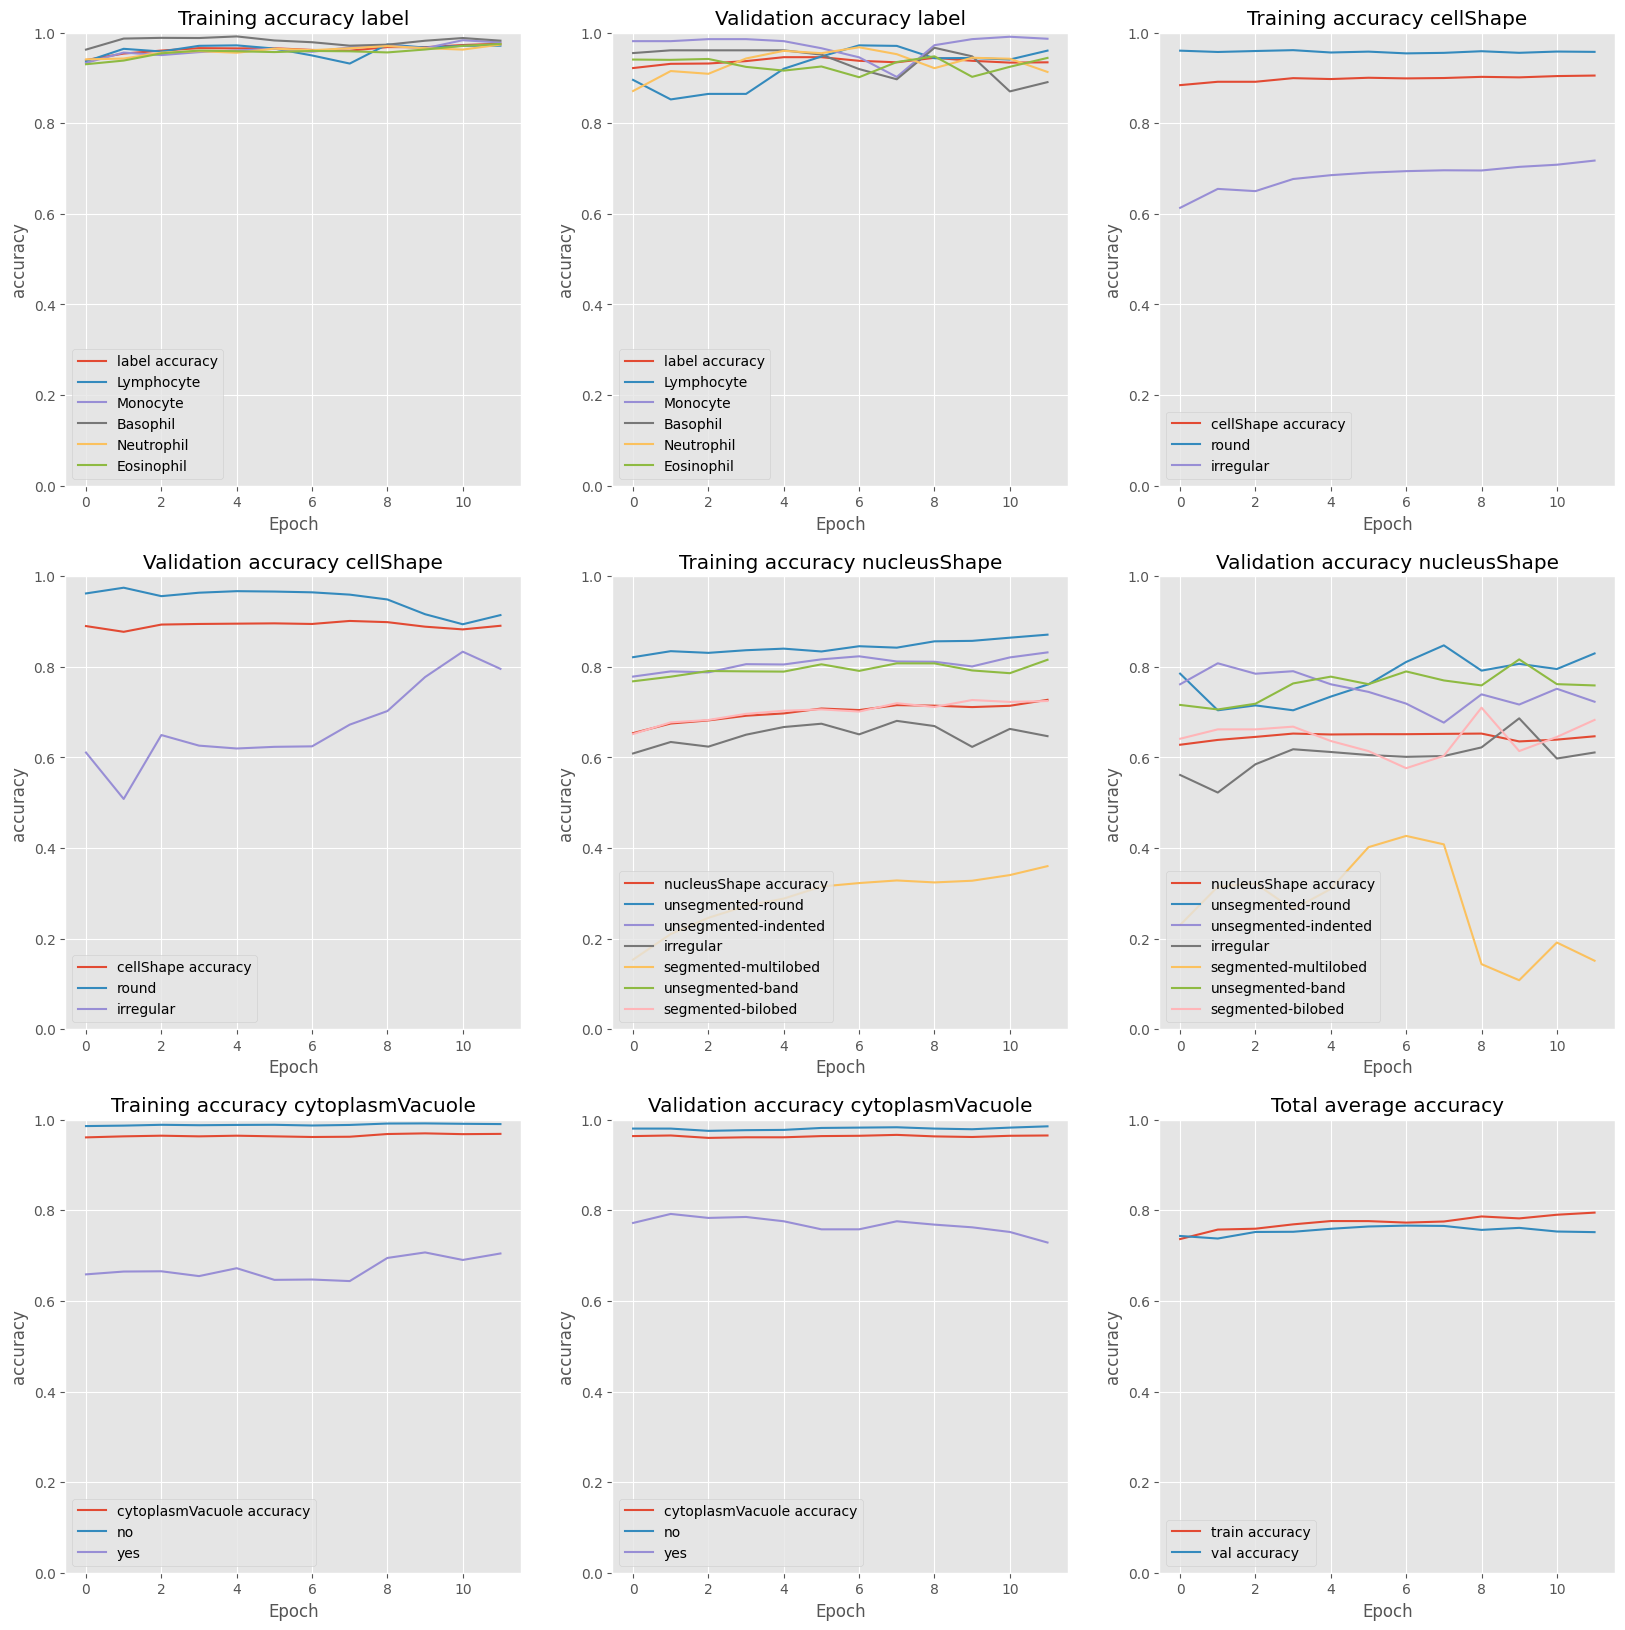

In [68]:
# Evaluation

plt.style.use("ggplot")
plt.figure(figsize=(20,20))
Nepoch=len(history.epoch)

targetMetricTrain = [0 for i in range(Nepoch)]
targetMetricVal = [0 for i in range(Nepoch)]
totalClasses = 0
totalWeights = 0

plotPos = 1
for outputType, outputClassWeights in classWeightsRaw.items(): 
	outputClassNames = list(outputClassWeights.keys())

	totalClasses += len(outputClassWeights)
	for i in range(len(outputClassWeights)):
		index = '' if i == 0 else f'_{i}'
		historyKey = f'{outputType}Output_class_accuracy{index}'
		
		inverseWeight = list(outputClassWeights.values())[i] ** -1
		totalWeights += inverseWeight

		for j in range(Nepoch):
			targetMetricTrain[j] += history.history[historyKey][j] *  inverseWeight
			targetMetricVal[j] += history.history[f'val_{historyKey}'][j] * inverseWeight

	plt.subplot(3,3,plotPos)
	plotPos += 1
	plt.plot(np.arange(0, Nepoch), history.history[f'{outputType}Output_accuracy'], label=f'{outputType} accuracy')

	for i in range(len(outputClassWeights)):
		index = '' if i == 0 else f'_{i}'
		key = f'{outputType}Output_class_accuracy{index}'
		
		plt.plot(np.arange(0, Nepoch), history.history[key], label=outputClassNames[i])

	plt.title(f"Training accuracy {outputType}")
	plt.ylim(0,1)
	plt.xlabel("Epoch")
	plt.ylabel("accuracy")
	plt.legend(loc="lower left")

	plt.subplot(3,3,plotPos)
	plotPos += 1
	plt.plot(np.arange(0, Nepoch), history.history[f'val_{outputType}Output_accuracy'], label=f'{outputType} accuracy')

	for i in range(len(outputClassWeights)):
		index = '' if i == 0 else f'_{i}'
		key = f'val_{outputType}Output_class_accuracy{index}'
		
		plt.plot(np.arange(0, Nepoch), history.history[key], label=outputClassNames[i])

	plt.title(f"Validation accuracy {outputType}")
	plt.ylim(0,1)
	plt.xlabel("Epoch")
	plt.ylabel("accuracy")
	plt.legend(loc="lower left")

targetMetricTrain = [i / totalWeights for i in targetMetricTrain]
targetMetricVal = [i / totalWeights for i in targetMetricVal]

plt.subplot(3,3,plotPos)
plt.plot(np.arange(0, Nepoch), targetMetricTrain, label='train accuracy')
plt.plot(np.arange(0, Nepoch), targetMetricVal, label='val accuracy')


plt.title("Total average accuracy")
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend(loc="lower left")

print(f'Average accuracy train: {targetMetricTrain[-1]}')
print(f'Average accuracy val: {targetMetricVal[-1]}')

plt.show()


## The first model

I chose to use the convocational layers from MobileNetV3Large as a base and then I started by adding a standard pooling layer followed by a 64 wide dense layer that was then directly connected to the 4 output layers.


In [47]:
# input and rescale
inputLayer = tf.keras.layers.Input(shape=(360, 360, 3))

# imagenet pre made model
baseModel = tf.keras.applications.MobileNetV3Large(
	weights='imagenet',  
	input_shape=(360, 360, 3),
	include_top=False,
	pooling='avg'
)

baseModel.trainable = False
convoLayers = baseModel(inputLayer, training=False)

# shared model layers
baseLayers = tf.keras.layers.Dense(64, activation='relu')(convoLayers)

#label 
labelLayers = baseLayers	
labelOutput = tf.keras.layers.Dense(len(labelTuple), activation='softmax', name='labelOutput')(labelLayers)

# cell shape
cellShapeLayers = baseLayers
cellShapeOutput = tf.keras.layers.Dense(len(cellShapeTuple), activation='softmax', name='cellShapeOutput')(cellShapeLayers)

# nucleus shape
nucleusShapeLayers = baseLayers
nucleusShapeOutput = tf.keras.layers.Dense(len(nucleusShapeTuple), activation='softmax', name='nucleusShapeOutput')(nucleusShapeLayers)

# cytoplasm vacuole
cytoplasmVacuoleLayers = baseLayers
cytoplasmVacuoleOutput = tf.keras.layers.Dense(len(cytoplasmVacuoleTuple), activation='softmax', name='cytoplasmVacuoleOutput')(cytoplasmVacuoleLayers)

model = tf.keras.Model(
	name='multi-task-classifier',
	inputs=inputLayer, 
	outputs={
		'labelOutput': labelOutput,
		'cellShapeOutput': cellShapeOutput,
		'nucleusShapeOutput': nucleusShapeOutput,
		'cytoplasmVacuoleOutput': cytoplasmVacuoleOutput,
		}
)

model.summary()

Model: "multi-task-classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 360, 360,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Large    │ (None, 960)       │  2,996,352 │ input_layer_6[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     61,504 │ MobileNetV3Large… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cellShapeOutput     │ (None, 2)         │        130 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cytoplasmVacuoleOu… │ (None, 2)         │        130 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labelOutput (Dense) │ (None, 5)         │        325 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nucleusShapeOutput  │ (None, 6)         │        390 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,058,831 (11.67 MB)

 Trainable params: 62,479 (244.06 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
model = tf.keras.models.lod_model('results/first.keras') 

### Results 

I trained this model for 8 epochs and it achieved an average accuracy of 58.4% on thr training set, but only 56.5% on the validation set. Suffice to say that this model is very inaccurate.

Takeing a more detailed look at the models performance the training began to drop off after the first few epochs but the validation set largely matched the training of the training so over fitting is not yet an issue.  


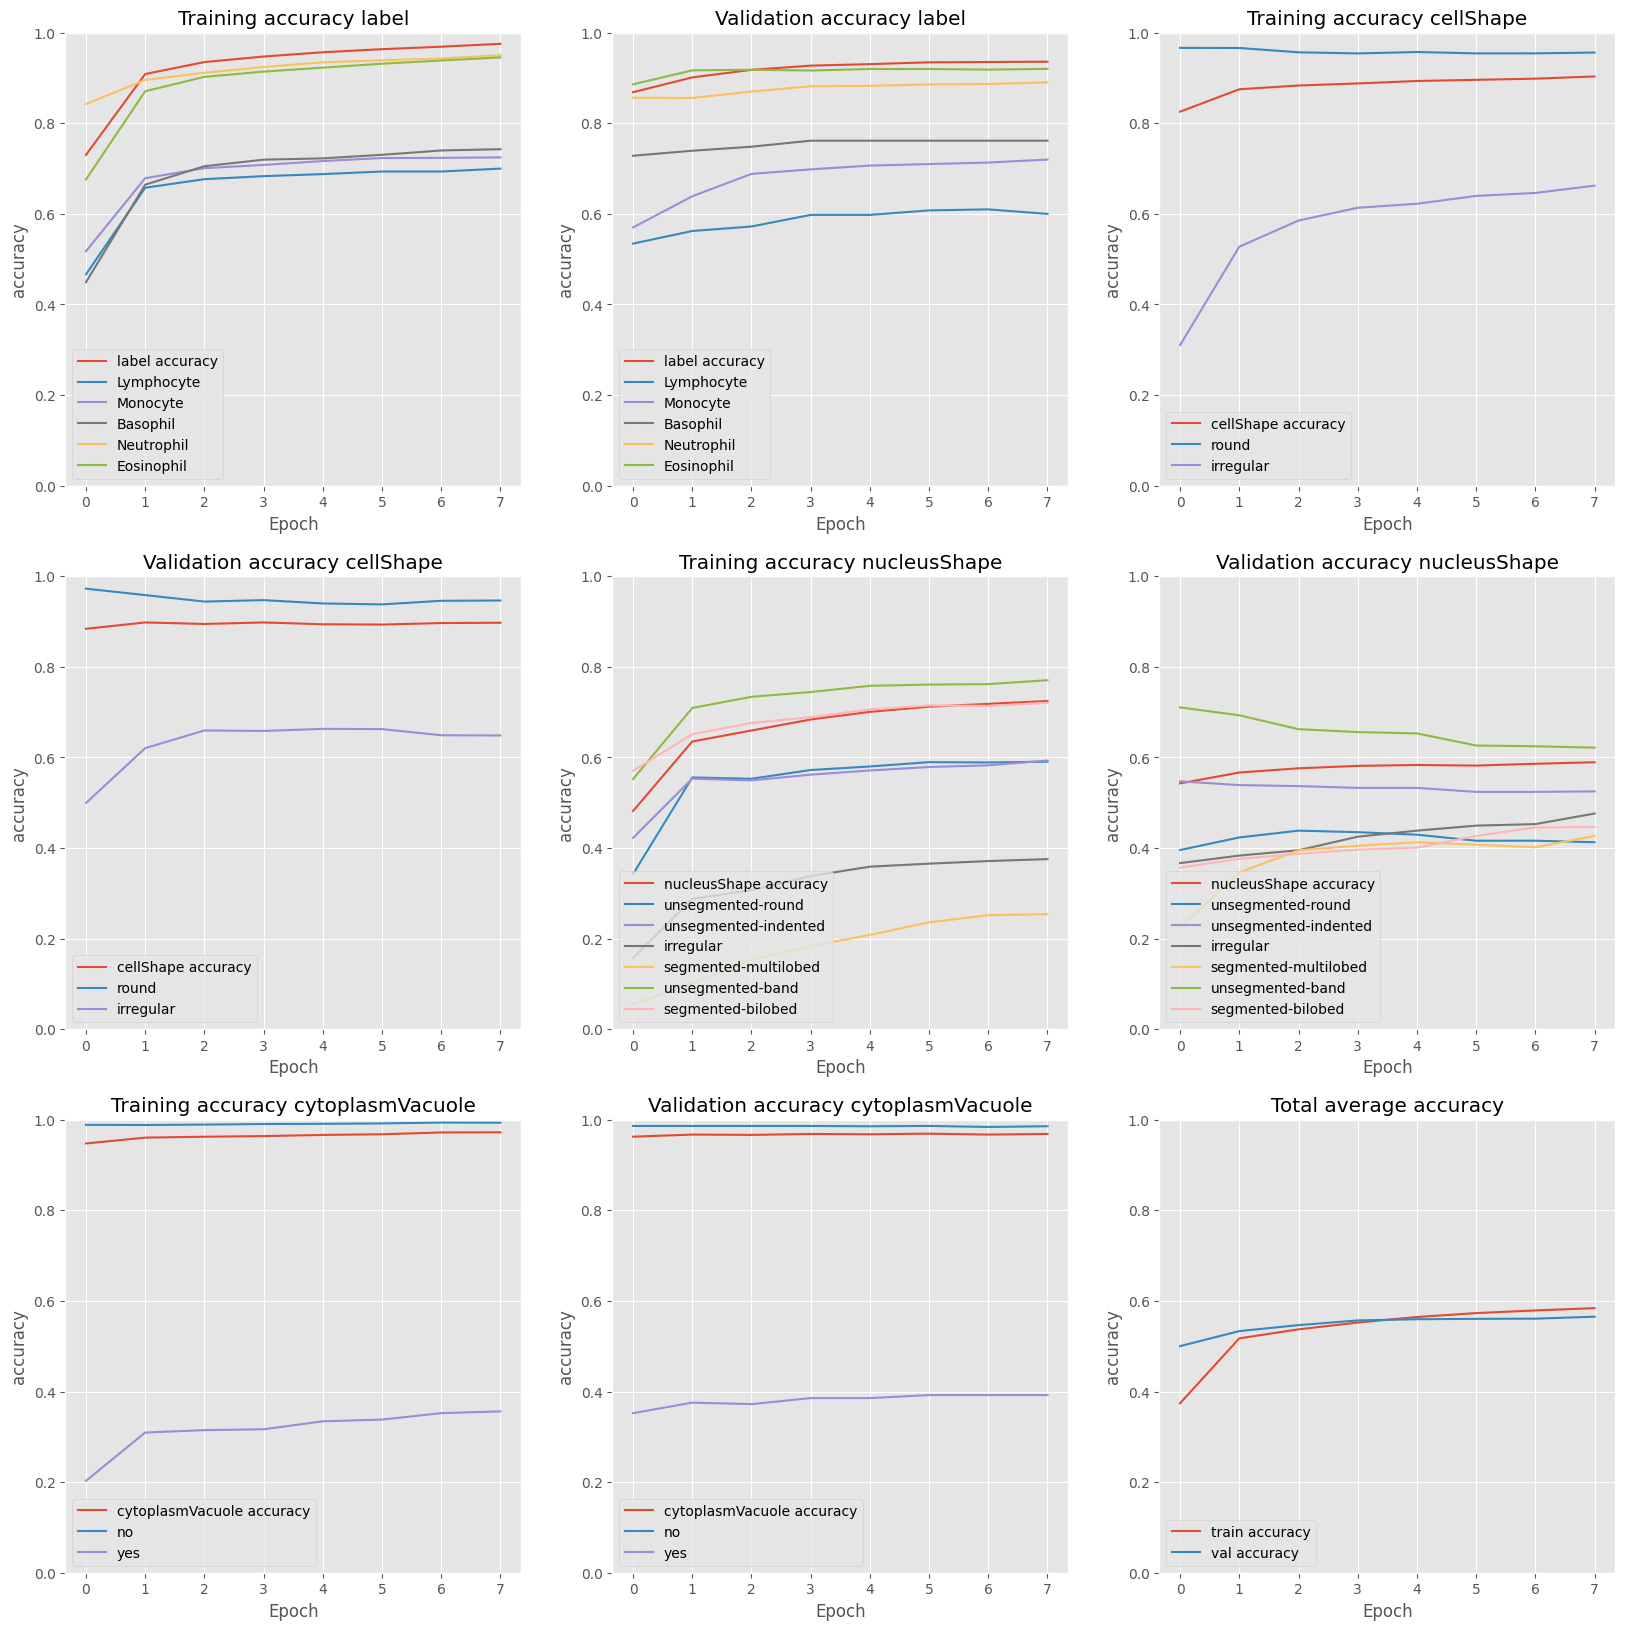

## The Second Model 

Based on the first modal results I decided to give each output its own dense layer in order to improve the capacity of the model.


In [ ]:
# input and rescale
inputLayer = tf.keras.layers.Input(shape=(360, 360, 3))

# imagenet pre made model
baseModel = tf.keras.applications.MobileNetV3Large(
	weights='imagenet',  
	input_shape=(360, 360, 3),
	include_top=False,
	pooling='avg'
)

baseModel.trainable = False
convoLayers = baseModel(inputLayer, training=False)

# shared model layers
baseLayers = tf.keras.layers.Dense(64, activation='relu')(convoLayers)

#label 
labelLayers = baseLayers	
labelLayers = tf.keras.layers.Dense(32, activation='relu')(labelLayers)
labelOutput = tf.keras.layers.Dense(len(labelTuple), activation='softmax', name='labelOutput')(labelLayers)

# cell shape
cellShapeLayers = baseLayers
cellShapeLayers = tf.keras.layers.Dense(32, activation='relu')(cellShapeLayers)
cellShapeOutput = tf.keras.layers.Dense(len(cellShapeTuple), activation='softmax', name='cellShapeOutput')(cellShapeLayers)

# nucleus shape
nucleusShapeLayers = baseLayers
nucleusShapeLayers = tf.keras.layers.Dense(32, activation='relu')(nucleusShapeLayers)
nucleusShapeOutput = tf.keras.layers.Dense(len(nucleusShapeTuple), activation='softmax', name='nucleusShapeOutput')(nucleusShapeLayers)

# cytoplasm vacuole
cytoplasmVacuoleLayers = baseLayers
cytoplasmVacuoleLayers = tf.keras.layers.Dense(32, activation='relu')(cytoplasmVacuoleLayers)
cytoplasmVacuoleOutput = tf.keras.layers.Dense(len(cytoplasmVacuoleTuple), activation='softmax', name='cytoplasmVacuoleOutput')(cytoplasmVacuoleLayers)

model = tf.keras.Model(
	name='multi-task-classifier',
	inputs=inputLayer, 
	outputs={
		'labelOutput': labelOutput,
		'cellShapeOutput': cellShapeOutput,
		'nucleusShapeOutput': nucleusShapeOutput,
		'cytoplasmVacuoleOutput': cytoplasmVacuoleOutput,
		}
)

model.summary()

/home/archfishgame/deep/deep-learning/.venv/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "multi-task-classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 360, 360,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Large    │ (None, 960)       │  2,996,352 │ input_layer_14[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │     61,504 │ MobileNetV3Large… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 32)        │      2,080 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 32)        │      2,080 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │      2,080 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │      2,080 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cellShapeOutput     │ (None, 2)         │         66 │ dense_21[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cytoplasmVacuoleOu… │ (None, 2)         │         66 │ dense_23[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labelOutput (Dense) │ (None, 5)         │        165 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nucleusShapeOutput  │ (None, 6)         │        198 │ dense_22[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,066,671 (11.70 MB)

 Trainable params: 70,319 (274.68 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
model = tf.keras.models.lod_model('results/second.keras') 

### Results 

While the training accuracy improved to 59.4%  the validation accuracy remained stagnant at 55.4%. This showed that the model was not meaning fully improving and looking at the data it was clear that the smaller classes had particularly bad accuracy for example the cytoplasm vacuole yes category never had an accuracy over 40% compared to the 90%+ accuracy of no.


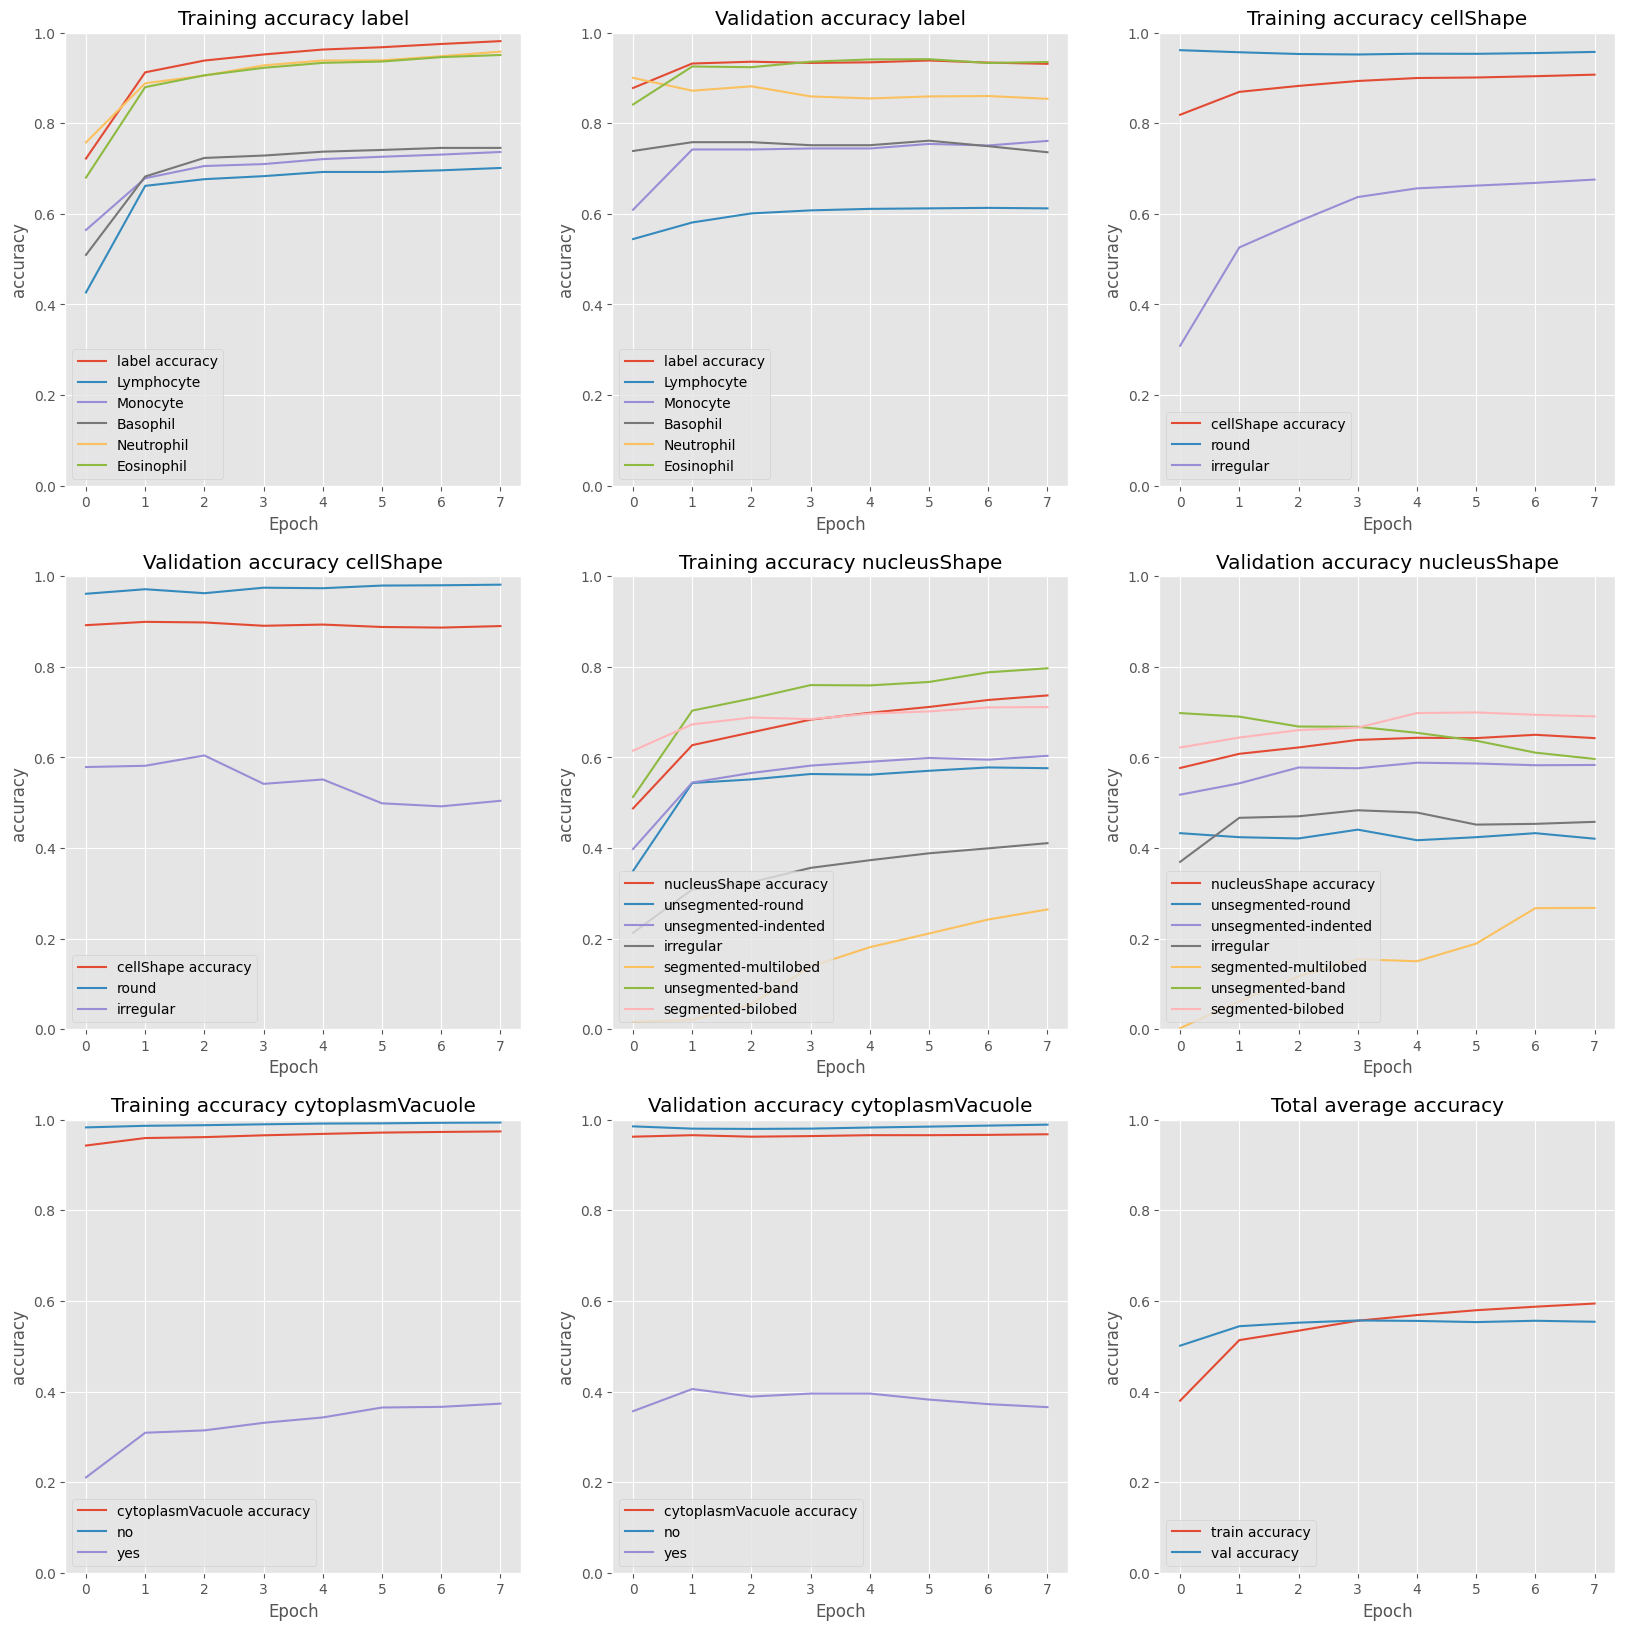

## The Third model 

For the first models I had limited the training to the layers I had added and disabled training on the pre-trained imagenet modal but since increasing the capacity of the modal made little difference and there was little sign of overfitting I decided to see if enabling training on the MobileNetV3Large convo layers would improve the performance.

In [ ]:
# input and rescale
inputLayer = tf.keras.layers.Input(shape=(360, 360, 3))

# imagenet pre made model
baseModel = tf.keras.applications.MobileNetV3Large(
	weights='imagenet',  
	input_shape=(360, 360, 3),
	include_top=False,
	pooling='avg'
)

baseModel.trainable = True
convoLayers = baseModel(inputLayer, training=True)

# shared model layers
baseLayers = tf.keras.layers.Dense(64, activation='relu')(convoLayers)

#label 
labelLayers = baseLayers	
labelLayers = tf.keras.layers.Dense(32, activation='relu')(labelLayers)
labelOutput = tf.keras.layers.Dense(len(labelTuple), activation='softmax', name='labelOutput')(labelLayers)

# cell shape
cellShapeLayers = baseLayers
cellShapeLayers = tf.keras.layers.Dense(32, activation='relu')(cellShapeLayers)
cellShapeOutput = tf.keras.layers.Dense(len(cellShapeTuple), activation='softmax', name='cellShapeOutput')(cellShapeLayers)

# nucleus shape
nucleusShapeLayers = baseLayers
nucleusShapeLayers = tf.keras.layers.Dense(32, activation='relu')(nucleusShapeLayers)
nucleusShapeOutput = tf.keras.layers.Dense(len(nucleusShapeTuple), activation='softmax', name='nucleusShapeOutput')(nucleusShapeLayers)

# cytoplasm vacuole
cytoplasmVacuoleLayers = baseLayers
cytoplasmVacuoleLayers = tf.keras.layers.Dense(32, activation='relu')(cytoplasmVacuoleLayers)
cytoplasmVacuoleOutput = tf.keras.layers.Dense(len(cytoplasmVacuoleTuple), activation='softmax', name='cytoplasmVacuoleOutput')(cytoplasmVacuoleLayers)

model = tf.keras.Model(
	name='multi-task-classifier',
	inputs=inputLayer, 
	outputs={
		'labelOutput': labelOutput,
		'cellShapeOutput': cellShapeOutput,
		'nucleusShapeOutput': nucleusShapeOutput,
		'cytoplasmVacuoleOutput': cytoplasmVacuoleOutput,
		}
)

model.summary()

/home/archfishgame/deep/deep-learning/.venv/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "multi-task-classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 360, 360,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_9         │ (None, 360, 360,  │          0 │ input_layer_11[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Large    │ (None, 960)       │  2,996,352 │ rescaling_9[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │     30,752 │ MobileNetV3Large… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cellShapeOutput     │ (None, 2)         │         66 │ dense_9[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cytoplasmVacuoleOu… │ (None, 2)         │         66 │ dense_9[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labelOutput (Dense) │ (None, 5)         │        165 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nucleusShapeOutput  │ (None, 6)         │        198 │ dense_9[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,027,599 (11.55 MB)

 Trainable params: 3,003,199 (11.46 MB)

 Non-trainable params: 24,400 (95.31 KB)

### Results

This change dramatically improved the models performance in the training dataset up to an accuracy of 65.5% but the validation dataset accuracy dropped to 35.5%. This showed that this modal was having major overfitting problems that needed to be addressed but I still think that the improved performance of allowing training on the convo layers is worth keeping. 

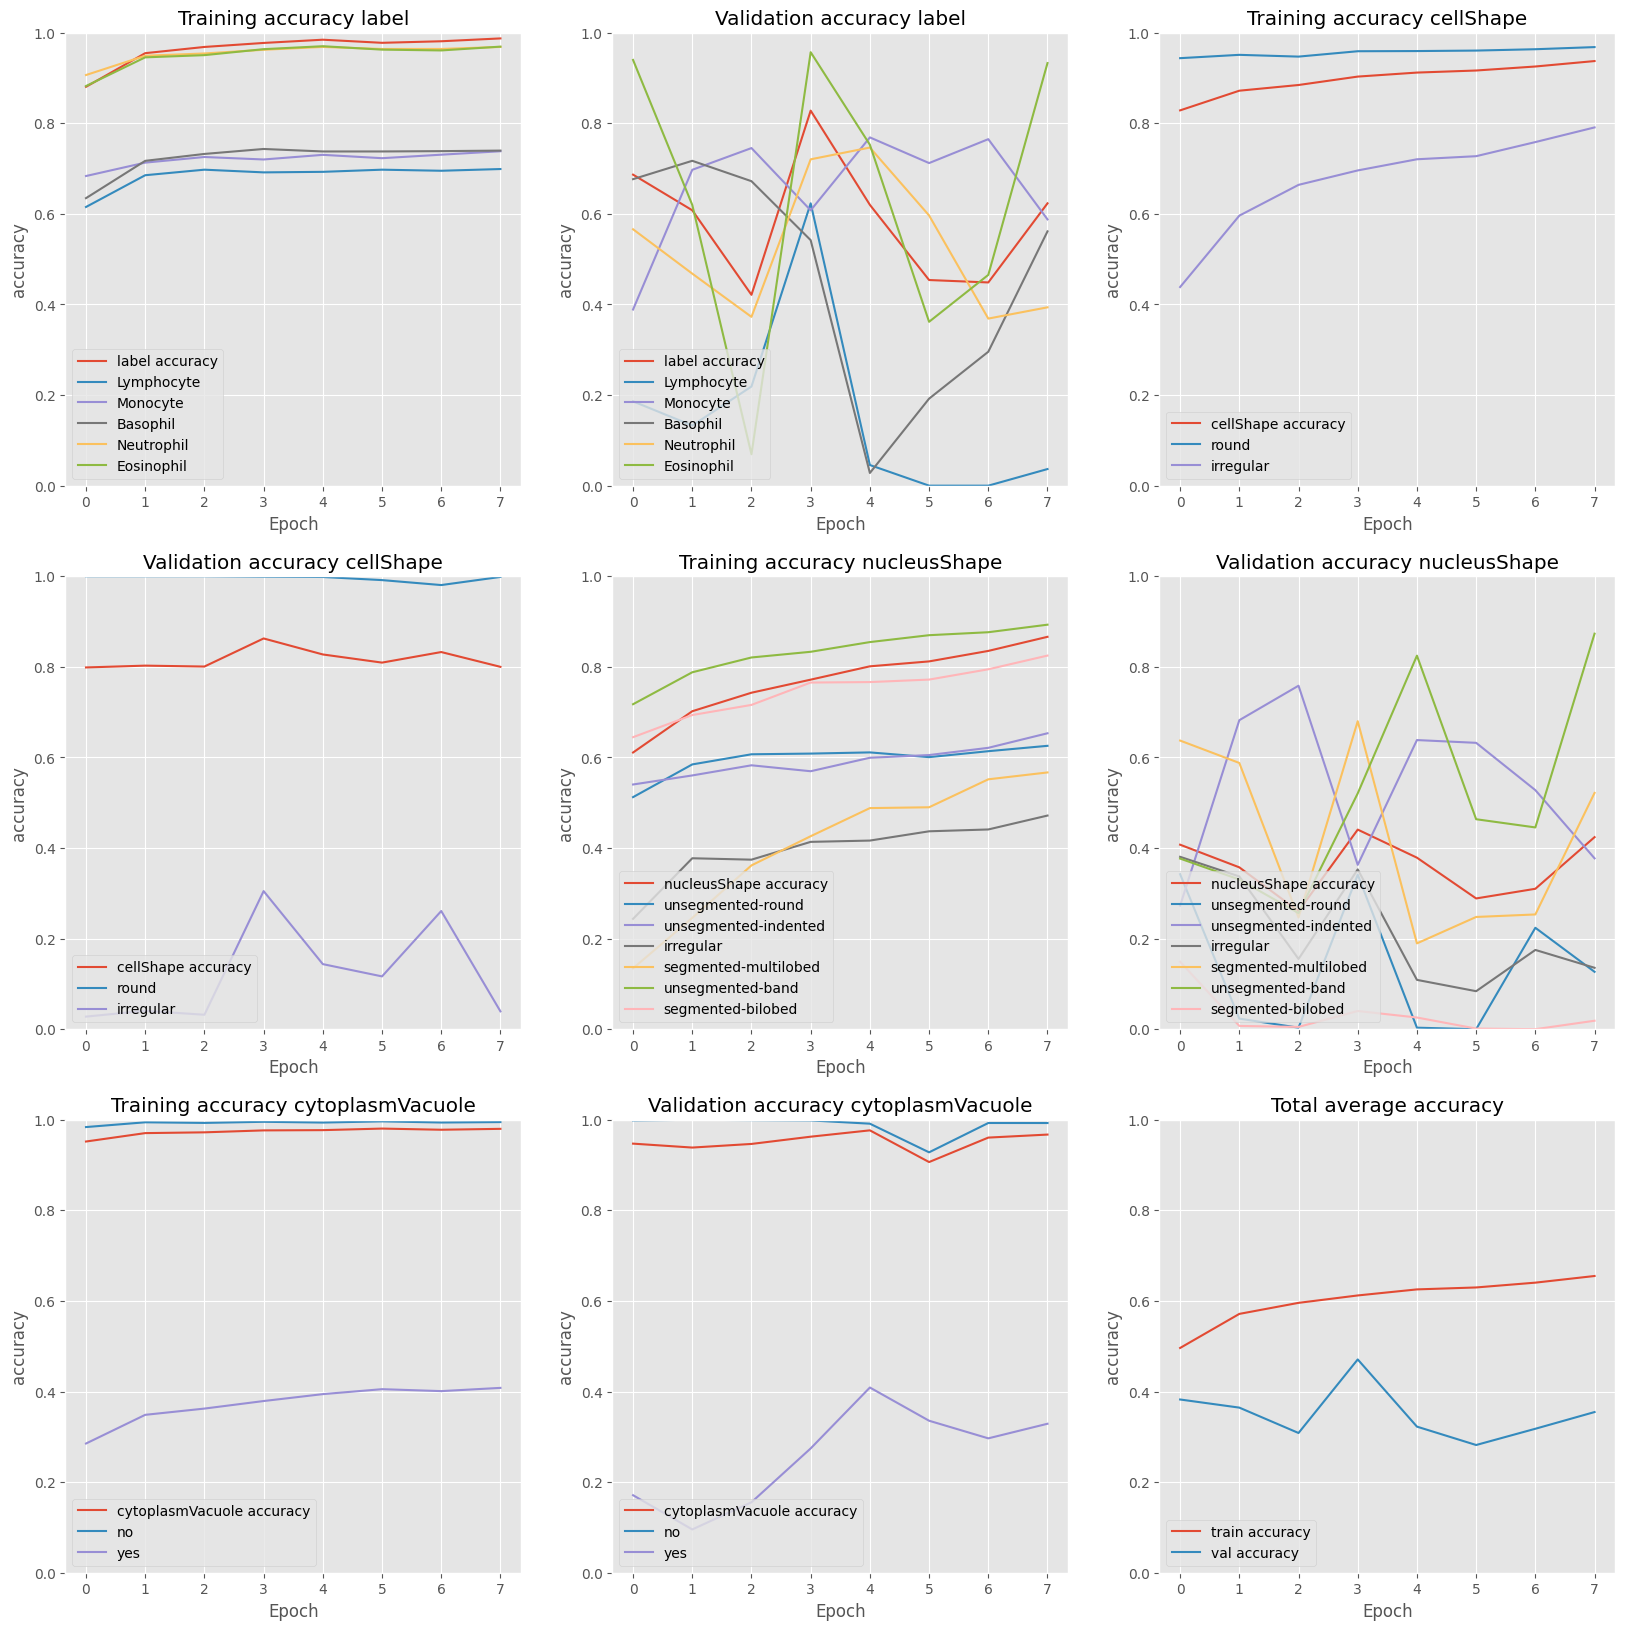

## The Forth Model

With this model I wanted to improve a

### Results 

This helped solve the problem and brought the training and validation accuracy closer together (61.6% and 44.2% respectively) but it was blaintently clear at this point that the model was overfitting the training data and that I needed to increase the size of the validation set to improve performance. 


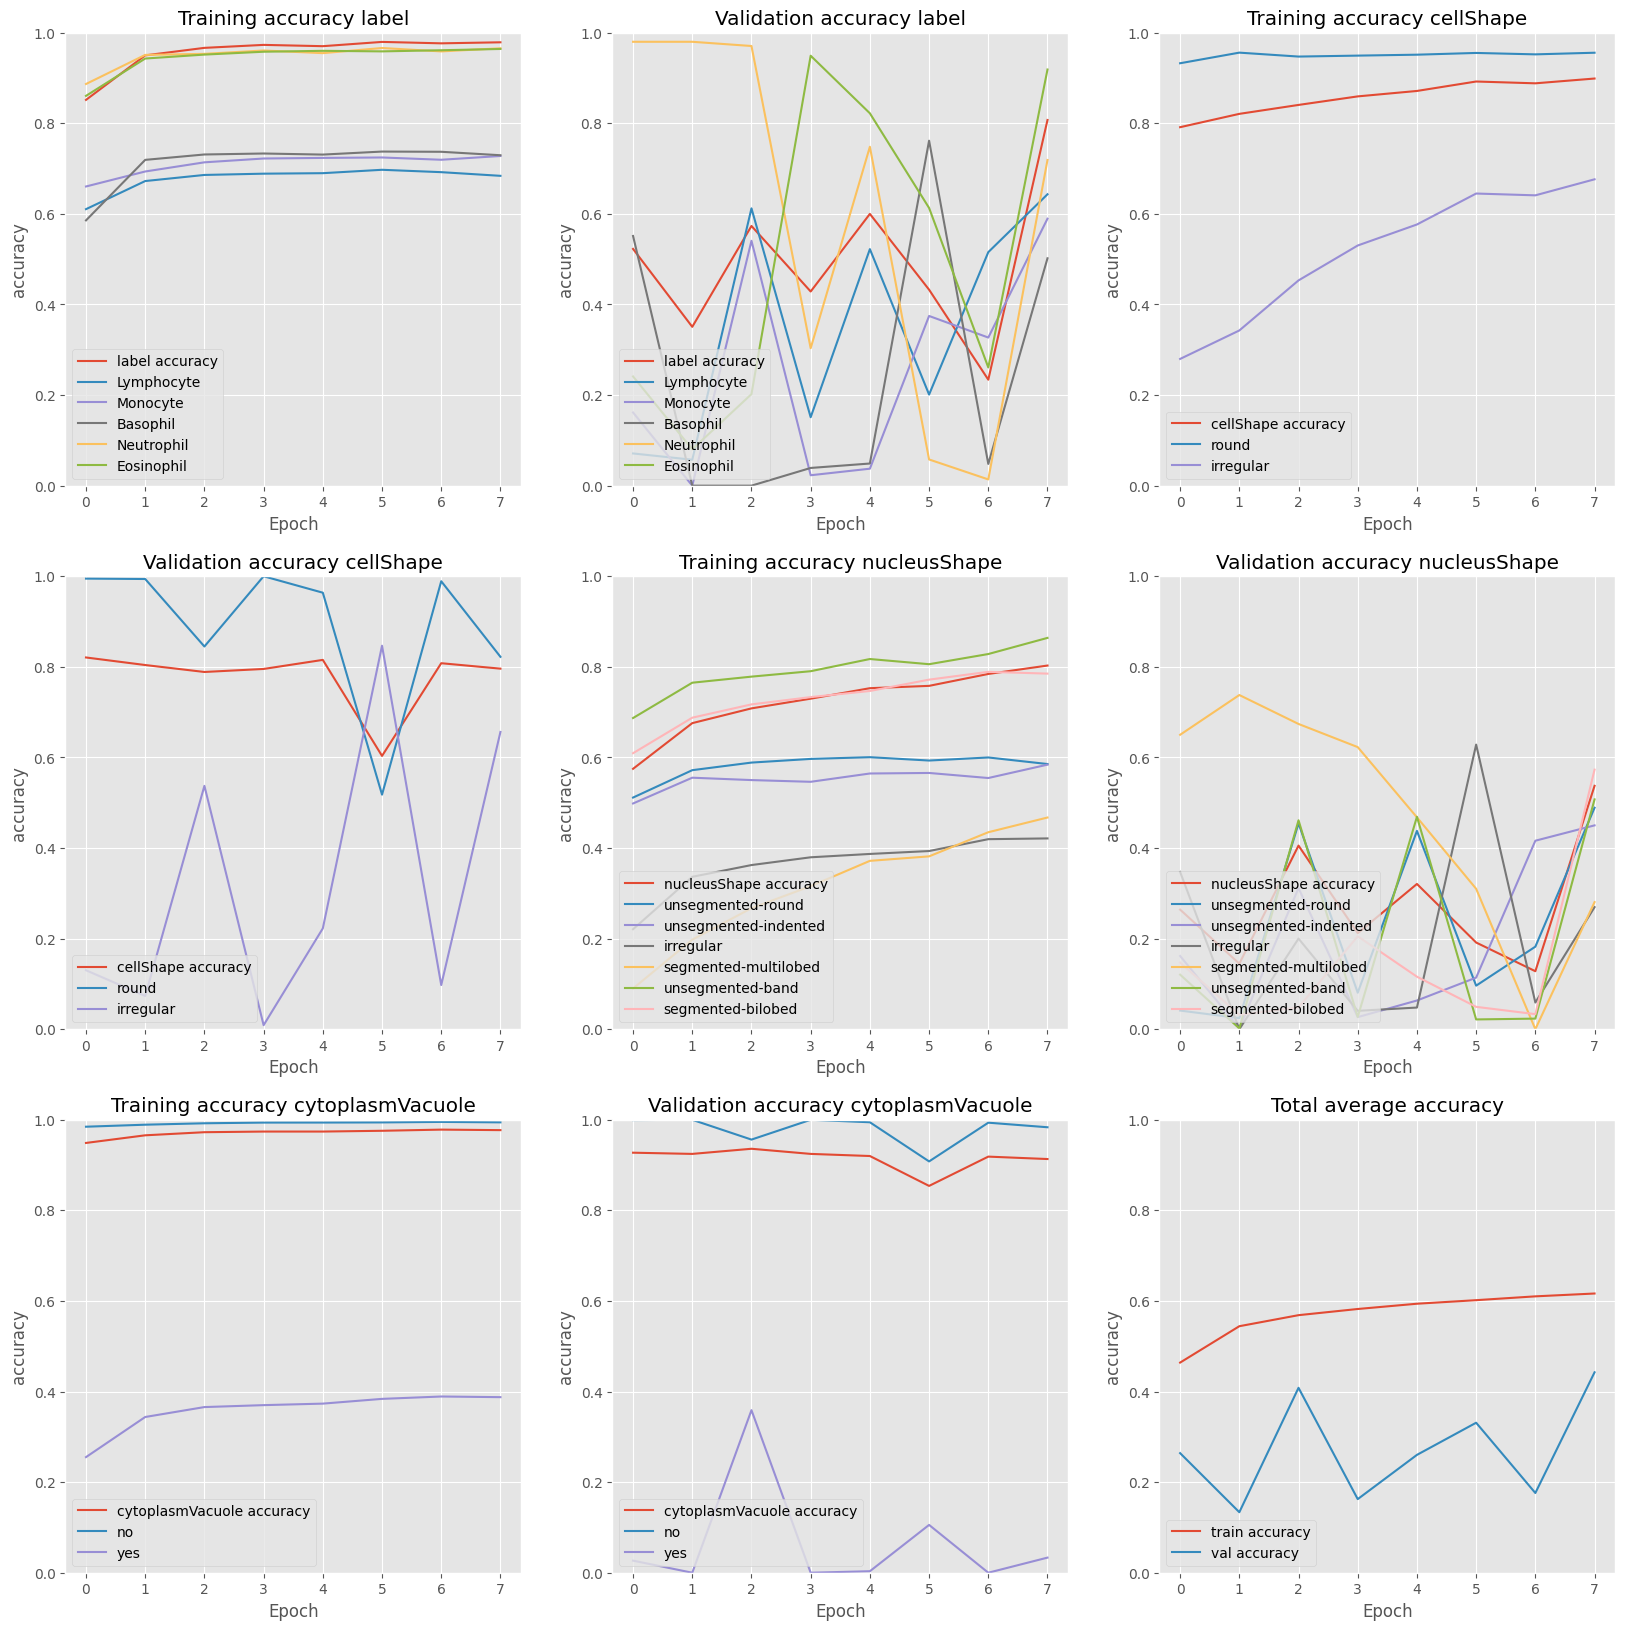

### 4.5 

I decided to train the 4th modal again but with an 60/40 split of the training and validation data as well as more weight given to the smaller classes.

In [ ]:
valSize = int(numTrainImages * 0.5)